In [1]:
##INPUT description
#
#This script requires two input files: 
#- the summary of the Benchflow tests ("dataFile") and 
#- the output file of the APM tools ("operationalProfile")
#
#dataFile has the following entry layout: ID,Users,Memory,CPU,CartReplicas,Metric,Microservice
#Metric has three possible string values: "Avg (sec)", "SD (sec)" and "Mix % (take failure into account)" 
#Microservice is the name of the microservice
#
#operationalProfile has the following entry layout: State - number of concurrent users,Frequency 

In [2]:
##SETTINGS

#Pre-requisites
install.packages("RColorBrewer")
library("RColorBrewer")

#Options
#TODO: If this is not 300, nothing works
max.num.users <- 300

#Preprocessing
allDataFileContent = readLines("benchflow_output.csv")

#We export files with the sep=, header and R does not handle that
skipFirstLine = allDataFileContent[-1] 

dataFile <- read.csv(textConnection(skipFirstLine), header=TRUE, sep=",")
operationalProfile <- read.csv("OperationalProfileData.csv", header=TRUE, sep=",")
usersLoad <- operationalProfile[,1]
accessCount <- operationalProfile[,2]
max.requests <- max(usersLoad)
scaleFactor <- max.num.users/max.requests
scaledUsersLoad <- floor(scaleFactor * usersLoad)

#Identify selected configurations from dataFile
mySettings <- unique(dataFile[,1:5])

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [3]:
##Create aggregate values (by fifty) of the user frequency from "operationalProfile" 
accessFrequency <- accessCount/sum(accessCount)
byFifty <- which(scaledUsersLoad %% 50 == 0)

binProb <- c()
for (i in 1:length(byFifty)) {
    if (i==1) {
        binProb[i] <- sum(accessFrequency[1:byFifty[i]])
    } else {
        binProb[i] <- sum(accessFrequency[(byFifty[i-1]+1):byFifty[i]])
    }
}

aggregatedValues <- matrix(c(scaledUsersLoad[byFifty], binProb), ncol=2, nrow=6, dimnames=list(c(1,2,3,4,5,6), c("Workload (number of users)", "Domain metric per workload")))

In [4]:
#Define the threshold for each service. The threshold is a vector computed as avg+3*SD for the configuration with 
#Users=2, Memory=4, CPU=1, CartReplica=1   

noMicroServices<-ncol(dataFile)-6
tempBench<-dataFile[dataFile$Users==2,]
benchSettings<-mySettings[mySettings$Users==2,]
avgVectorB<-tempBench[tempBench$Metric=="Avg (sec)",][,-c(1:6)]
SDVectorB<- tempBench[tempBench$Metric=="SD (sec)",][,-c(1:6)]
mixB<-tempBench[tempBench$Metric=="Mix % (take failure into account)",][,-c(1:6)]
threshold<-data.frame(benchSettings,avgVectorB+3*SDVectorB)

In [5]:
#Exclude case with user = 2 from dataFile and check whether each service passes or fail: avg<threshol (Pass). 
#Compute the relative mass for each configuration

#Select relevant rows
usedSettings<-mySettings[!mySettings$Users==2,]
usedDataFile<-dataFile[!dataFile$Users==2,]
avg<-usedDataFile[usedDataFile$Metric=="Avg (sec)",-6]
SD<-usedDataFile[usedDataFile$Metric=="SD (sec)",-6]
mixTemp<-usedDataFile[usedDataFile$Metric=="Mix % (take failure into account)",-6]

#Check pass/fail for each service. the "mix" value is 0 if fail and mixTemp if pass. Compute the relative mass for each configuration
passCriteria<-avg
relativeMass<-c()
#colnames(passCriteria)<-c(colnames(dataFile[-6]))
mix<-as.data.frame(matrix(nrow=nrow(usedSettings), ncol=ncol(usedDataFile)-1))
for(j in 1:nrow(passCriteria)){
    mix[j,]<-mixTemp[j,]
    for(i in 6:(5+noMicroServices)){
        if(passCriteria[j,i]>threshold[i]){mix[j,i]<-0}
    }
    relativeMass[j]<-sum(mix[j,6:(5+noMicroServices)])
}

In [6]:
#Compute the domain metric for each configuration

tempData<-usedSettings
tempData$relativeMass<-relativeMass
absoluteMass<-c()
for(j in 1:nrow(tempData)){
    absoluteMass[j]<-tempData[j,"relativeMass"]*aggregatedValues[match(tempData[j,"Users"], aggregatedValues[,1]),2]
}
#head(finalSettings)
tempData$absoluteMass<-absoluteMass

mySettingsUnique<-unique(tempData[3:5])
set<-list()
domainMetricList<-list()
for(i in 1:nrow(mySettingsUnique)){
    set[[i]]<-tempData[which(tempData[,3] == mySettingsUnique[i,1]&tempData[,4] == mySettingsUnique[i,2]&tempData[,5] == mySettingsUnique[i,3]),]
    domainMetricList[[i]]<-set[[i]][,c(2,7)][order(set[[i]][,c(2,7)][,1]),]
}

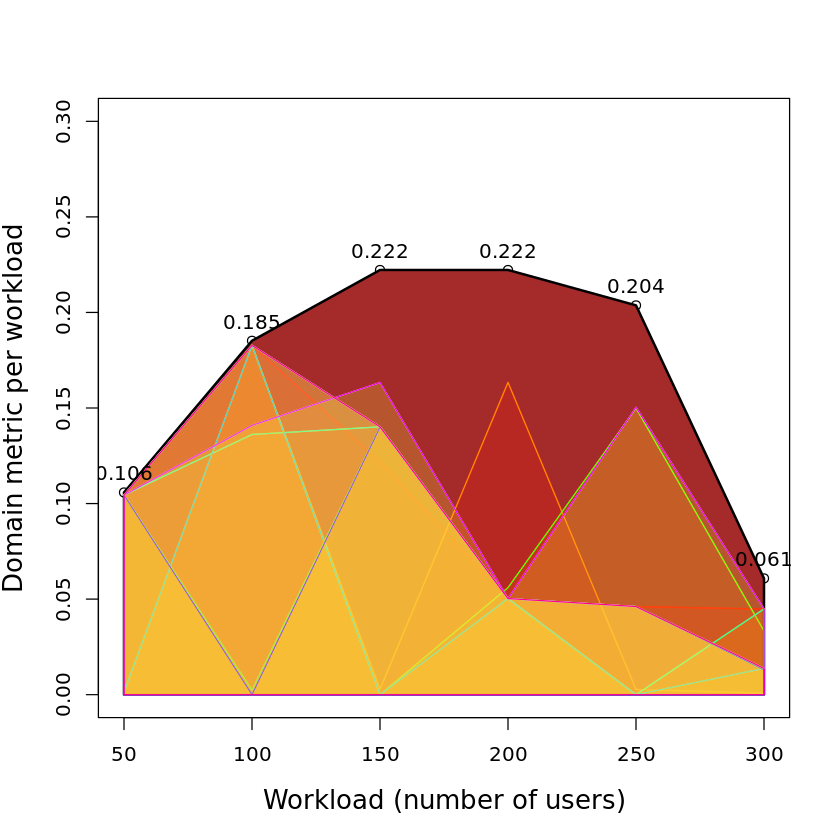

In [7]:
#Plot operationalProfile against domain metric for each configuration

#graphics.off()
#jpeg(filename="Polygons.jpeg", width = 480, height = 480, units = "px", pointsize = 12, quality = 75, bg = "white", res = NA)
plot(aggregatedValues, xlim=c(50, 300), ylim=c(0, 0.3),cex.lab=1.3)
polygon(c(50,aggregatedValues[,1],300),c(0,aggregatedValues[,2],0), col="brown", lty = 1, lwd = 2, border = "black")
color=heat.colors(11)
color_transparent <- adjustcolor(color, alpha.f = 0.2) 

for(i in 1:nrow(mySettingsUnique)) {
    lines(domainMetricList[[i]], type="l", col=heat.colors(11)[i])    
    polygon(c(50,t(domainMetricList[[i]][1]),300),c(0,t(domainMetricList[[i]][2]),0), col=color_transparent[i], lty = 1, lwd = 1 , border = rainbow(11)[i])
}

text(aggregatedValues,labels = round(aggregatedValues[1:6,2],3), pos=3, col="black")
#graphics.off()

In [8]:
#Compute Domain metric: summing up absoluteMass over users for each configuration

install.packages("gridExtra")

mySettingsUnique$domainMetric<-0
for(i in 1:nrow(mySettingsUnique)){
    mySettingsUnique[i,4]<-round(sum(tempData[which(tempData[,3] == mySettingsUnique[i,1]&tempData[,4] == mySettingsUnique[i,2]&tempData[,5] == mySettingsUnique[i,3]),"absoluteMass"]),4)
}
domainMetric<-mySettingsUnique
#Create the Table of the domain metric
library(ggplot2)
library(gridExtra)
pdf("Table.pdf", height=5, width=5)

#svg("Mirai/table.svg",width = 7, height = 7, pointsize = 12, onefile = FALSE, family = "sans", bg = "white",antialias = c("default", "none", "gray", "subpixel"))
p<-tableGrob(domainMetric[order(domainMetric[,1],domainMetric[,2],domainMetric[,3]),], rows=NULL)
grid.arrange(p)
dev.off()

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


png 
  2